In [5]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

UsageError: Line magic function `%install_ext` not found.


In [778]:
import mlxtend
import numpy as np
import pandas as pd
import re

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time
from functools import wraps

from scipy import stats

from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import k_means_

from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, cosine_distances

from sklearn.decomposition import PCA

from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.metrics import silhouette_score
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Resumo

O objetivo deste notbook é executar o trablho da disciplina de Data Mining I. O enunciado pedia que:

* Encontrássemos clusters de filmes semelhantes usando as notas dadas pelos usuários como features do modelo.
* Para lidar com o grande número de dimensões dos vetores de features, deveríamos usar uma transformada PCA para reduzir a dimensão do prodlema.
* Utilizar os algoritmos: KMeans e DBScan para gerar os clusters

A bases de 100k e 1M já haviam sido tratadas no trabalho anterior, por isso nenhum pré-processamento de limpeza dos dados foi feito. A ordem do Notebbok, seguiu o processo de experimentação realmente executado. Caso apenas as conclusões sejam de interesse, a sessão de conclusão resume o que foi encontrado.

# Importando o dataset

dataset depois do tratamento feito para a análise de Market Basket. 

In [779]:
ratingsDF = pd.read_pickle("..\\ProcessedData\\df.pkl")

In [780]:
ratingsDF.head()

,uid,id,rating,timestamp,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,1997-12-04 15:55:49,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,1997-10-01 23:06:30,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,1998-01-04 04:37:51,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,1997-11-10 05:03:55,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,1997-10-10 17:16:33,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [781]:
print("Número de usuários na base %i" % ratingsDF['uid'].nunique())

Número de usuários na base 943


In [782]:
print("Número de filmes na base %i" % ratingsDF['id'].nunique())

Número de filmes na base 1664


## Criando os vetores de features dos filmes

Cada filme será representado pelas notas que cada um dos usuários da base deu para aquele filme. O que siginifica que **cada filme será representado por vetores esparsos de tamanho 943**.

Sabemos da exploração que não há duplicatas para a chave **uid, id**, então:

In [783]:
ratings_id = ratingsDF.groupby(['id']).aggregate({'rating': len})

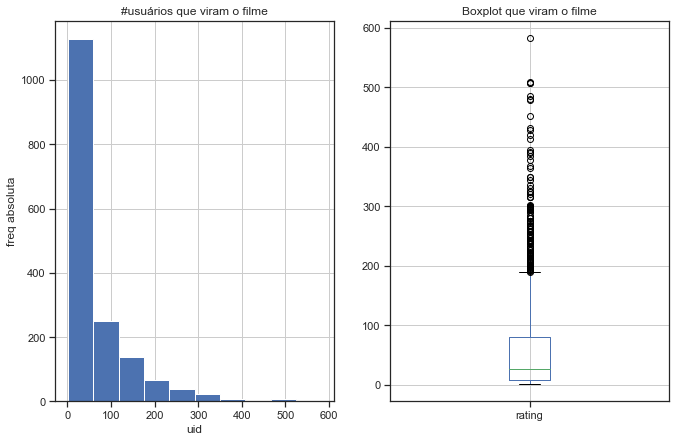

In [784]:
plt.figure(),
plt.subplot(1,2,1)
ratings_id.rating.hist()
plt.grid(True)
plt.title("#usuários que viram o filme")
plt.xlabel("uid")
plt.ylabel("freq absoluta")

plt.subplot(1,2,2)
ratings_id.boxplot()
plt.title("Boxplot que viram o filme")
plt.rcParams['figure.figsize'] = (11,7)
plt.show()

In [785]:
print("Moda do número de usuários que viram o filme: %i" % ratings_id.rating.mode())
print("Média do número de usuários que viram o filme: %i" % ratings_id.rating.mean())

Moda do número de usuários que viram o filme: 1
Média do número de usuários que viram o filme: 59


In [786]:
print("Número de filmes com apenas uma avaliação: %i" % (ratings_id.rating == 1).sum())

Número de filmes com apenas uma avaliação: 135


## Filmes mais vistos

Para depois achar quais so clusters dos filmes mais populares. Vou definer como sendo um filme muito visto aquele com mais de 150 usuários damdp mota diferente de 0

In [787]:
popular_film = (ratings_id.rating > 150)

In [788]:
print("número de filmes populares %i" % popular_film.sum())

número de filmes populares 202


In [789]:
popular_ids = popular_film[popular_film]

abaixo uma amostra das notas dadas aos filmes populares

In [790]:
ratingsDF[ratingsDF['id'].isin(popular_ids.index)].sample(10)

,uid,id,rating,timestamp,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
76166,193,282,5,1998-03-05 19:09:25,"Time to Kill, A (1996)",1996-07-13,http://us.imdb.com/M/title-exact?Time%20to%20K...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62702,788,230,3,1997-11-30 06:02:34,Star Trek IV: The Voyage Home (1986),1986-01-01,http://us.imdb.com/M/title-exact?Star%20Trek%2...,0,1,1,...,0,0,0,0,0,0,1,0,0,0
51056,182,50,5,1998-01-24 03:36:58,Star Wars (1977),1977-01-01,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,...,0,0,0,0,0,1,1,0,1,0
76697,113,300,3,1997-09-24 04:38:07,Air Force One (1997),1997-01-01,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,...,0,0,0,0,0,0,0,1,0,0
30038,910,127,5,1997-11-29 16:47:40,"Godfather, The (1972)",1972-01-01,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,...,0,0,0,0,0,0,0,0,0,0
8309,791,322,4,1997-11-13 19:08:48,Murder at 1600 (1997),1997-04-18,http://us.imdb.com/M/title-exact?Murder%20at%2...,0,0,0,...,0,0,0,0,1,0,0,1,0,0
25343,79,258,5,1998-03-30 15:21:48,Contact (1997),1997-07-11,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,...,0,0,0,0,0,0,1,0,0,0
67664,184,393,4,1998-03-14 21:09:48,Mrs. Doubtfire (1993),1993-01-01,http://us.imdb.com/M/title-exact?Mrs.%20Doubtf...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16002,508,208,5,1998-01-02 21:32:28,Young Frankenstein (1974),1974-01-01,http://us.imdb.com/M/title-exact?Young%20Frank...,0,0,0,...,0,0,1,0,0,0,0,0,0,0
11156,230,427,5,1997-11-25 19:01:41,To Kill a Mockingbird (1962),1962-01-01,http://us.imdb.com/M/title-exact?To%20Kill%20a...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Criando a versão pivoteada do dataset

In [791]:
def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().str.join('')
    return df

In [792]:
%%time
df_pivoted = pd.pivot_table(ratingsDF, columns=['uid'], values=['rating'], index=['id'], aggfunc=np.max)

Wall time: 1min 16s


In [793]:
# df_pivoted.fillna(0, inplace=True)

In [794]:
df_flattern = df_pivoted.copy()
df_flattern.columns = df_pivoted.columns.get_level_values(1)

In [795]:
df_flattern.head(10)

uid,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
2,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.0,NaN,NaN,NaN,NaN,2.0,5.0,3.0,4.0,4.0,...,NaN,NaN,4.0,NaN,4.0,NaN,4.0,4.0,NaN,NaN
8,1.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
9,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,4.0,...,NaN,1.0,4.0,5.0,3.0,5.0,3.0,NaN,NaN,3.0


## Formato Esparso do dataset

o dataset pode ser codificado de forma esparsa antes do fill de NaN pelas médias, talvez gere ganho

In [796]:
df_pivoted_spase = df_flattern.to_sparse()

## Fill de valores nulos

Os algoritimos que vamos utilizar são sensíveis aos valores nulos. Para diminuir esse efeito, podemos substituir zeros pela média das notas dos filmes desconsiderando os valores 0 (que são NAN na verdade);

In [797]:
filmMeanRating = df_pivoted.mean(axis=1)

> Obs: a função fill na por linha não está implementada no Pandas, por isso as transposições

In [798]:
df_flattern = df_flattern.T.fillna(filmMeanRating).T

In [799]:
df_flattern.T.describe()

id,1,2,3,4,5,6,7,8,9,10,...,1672,1673,1674,1675,1676,1677,1678,1679,1681,1682
count,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,...,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0
mean,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
std,0.642041,0.359043,0.372773,0.453487,0.284302,0.212022,0.632690,0.482161,0.586278,0.309907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
25%,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
50%,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
75%,4.000000,3.206107,3.033333,3.550239,3.302326,3.576923,4.000000,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0


In [800]:
df_flattern.to_pickle('films_features.pkl')

# Decomposição do vetor de features

## PCA

In [801]:
pca_dim = 943

In [802]:
pca = PCA(n_components=pca_dim).fit(df_flattern)

In [803]:
cumulativeVar = pd.Series(pca.explained_variance_ratio_.cumsum())

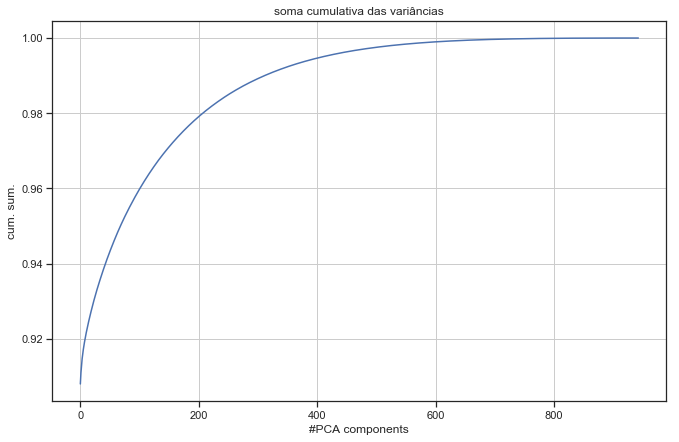

In [804]:
plt.figure(),
cumulativeVar.plot()
plt.grid(True)
plt.title("soma cumulativa das variâncias")
plt.xlabel("#PCA components")
plt.ylabel("cum. sum.")
plt.show()

a variância ao longo das 5 primeiras dimensões já é da ordem de **e-5**. Se reduzirmos o número de dimensões para apenas 2 temos:

In [805]:
pca_dim = 3
pca = PCA(n_components=pca_dim).fit(df_flattern)

In [806]:
print("energia conservada pelas %i primeiras componentes do PCA %f" % (pca_dim, pca.explained_variance_ratio_.sum())) 

energia conservada pelas 3 primeiras componentes do PCA 0.912999


In [807]:
df_pca = pd.DataFrame(pca.transform(df_flattern))

Data Scatter

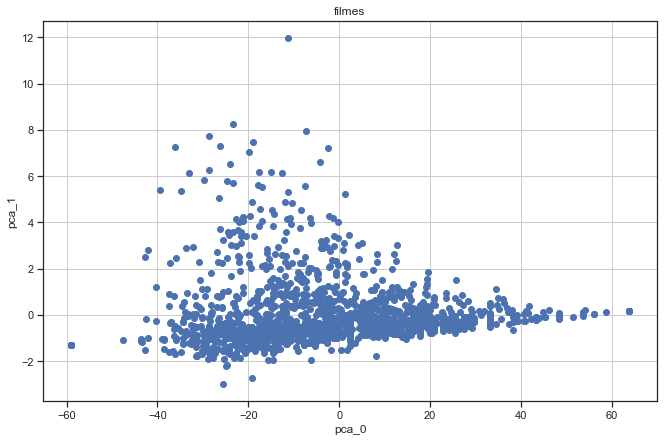

In [808]:
# plt.figure().gca(projection='3d')
plt.figure()
# plt.scatter(df_pca[0], df_pca[1], df_pca[2])
plt.scatter(df_pca[0], df_pca[1])
plt.grid(True)
plt.title("filmes")
plt.xlabel("pca_0")
plt.ylabel("pca_1")
plt.show()

# Clusterização

Posdemos executar a clusterização no espaço não transformado pelo PCA enquanto isso não gerar problemas de desempenho. Pode-se usar o PCA para fazer a projeção para 2D e faciliar a visualização dos clustes

In [809]:
# %%time
# plot_learning_curve(
#     estimator=kmeans, # clustering algorithm
#     X=df_pivoted,y=None, # None for unsupervisioned
#     train_sizes=(1.0,), # all for training
#     cv=10, #cross-validation maninfolds    
#     title="kmeans learning"
# )

## Kmeans usando a norma L2 como medida de dessimilaridade

Primeiro devemos determinar o número de clusters

### Treinamento

Para determinar o número de clusters, procuramos por um joelho na gráfico de loss (norma L@) vs número de clusters

In [ ]:
th_min = 0
th_max = 2
n_clusters_range = np.rint(np.logspace(th_min,th_max,num=30))

In [ ]:
scores = []
time_elapsed = []

In [ ]:
df_for_clustering = df_pca

In [ ]:
%%time
for n in n_clusters_range:
    start_time = time.time()
    kmeans = KMeans(n_clusters=int(n)).fit(df_for_clustering)
    elapsed_time = time.time() - start_time
    scores.append(kmeans.inertia_)
    time_elapsed.append(elapsed_time)

Wall time: 4.7 s


A inércia dividida pelo número de pontos na base dá a noção da distância média entre os pontos e seus clusters, que é uma quantidade mais intuitiva

In [ ]:
scores = np.array(scores)/len(df_for_clustering)

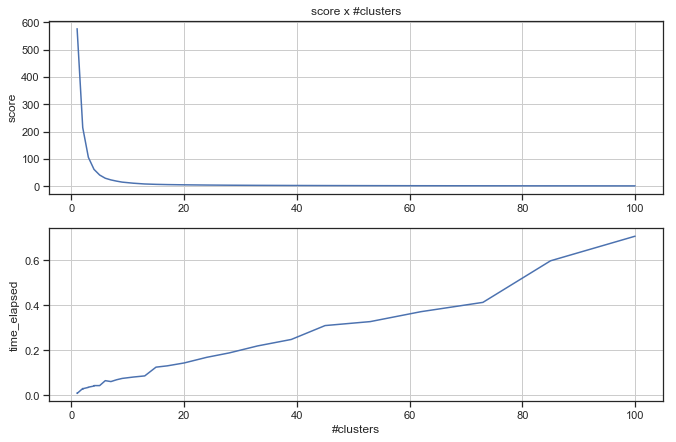

In [ ]:
plt.figure(),
plt.subplot(2,1,1)
plt.plot( n_clusters_range, scores)
plt.grid(True)
plt.title("score x #clusters")
plt.ylabel("score")
plt.subplot(2,1,2)
plt.plot( n_clusters_range, time_elapsed)
plt.grid(True)
plt.xlabel("#clusters")
plt.ylabel("time_elapsed")
plt.show()

In [ ]:
#Scaling of data
# ss = StandardScaler()
# ss.fit_transform(df_pivoted_sparse)

clust_labels = kmeans.labels_

Por inspeção, há um joelho entre 10 e 20, vou repetir a análise para aumentar o range de 10 a 20

In [ ]:
n_clusters_range2 = np.linspace(5,20,num=10)

In [ ]:
scores2 = []
time_elapsed2 = []

In [ ]:
%%time
for n in n_clusters_range2:
    start_time = time.time()
    kmeans = KMeans(n_clusters=int(n)).fit(df_for_clustering)
    elapsed_time = time.time() - start_time
    scores2.append(kmeans.inertia_)
    time_elapsed2.append(elapsed_time)

Wall time: 966 ms


A inércia dividida pelo número de pontos na base dá a noção da distância média entre os pontos e seus clusters, que é uma quantidade mais intuitiva

In [ ]:
scores2 = np.array(scores2)/len(df_for_clustering)

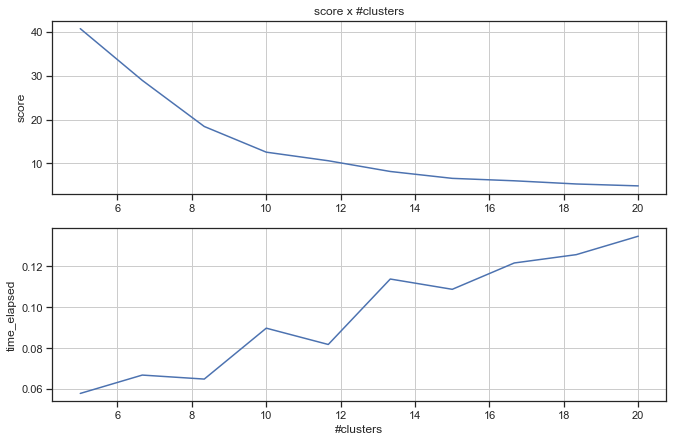

In [ ]:
plt.figure(),
plt.subplot(2,1,1)
plt.plot( n_clusters_range2, scores2)
plt.grid(True)
plt.title("score x #clusters")
plt.ylabel("score")
plt.subplot(2,1,2)
plt.plot( n_clusters_range2, time_elapsed2)
plt.grid(True)
plt.xlabel("#clusters")
plt.ylabel("time_elapsed")
plt.show()

Por inspeção n=10, parece uma boa definição para o joelho

In [ ]:
n_ = 10
kmeans = KMeans(n_clusters=n_).fit(df_for_clustering)

In [ ]:
clust_labels = kmeans.labels_

In [ ]:
df = df_for_clustering.copy()
df['cluster'] = clust_labels

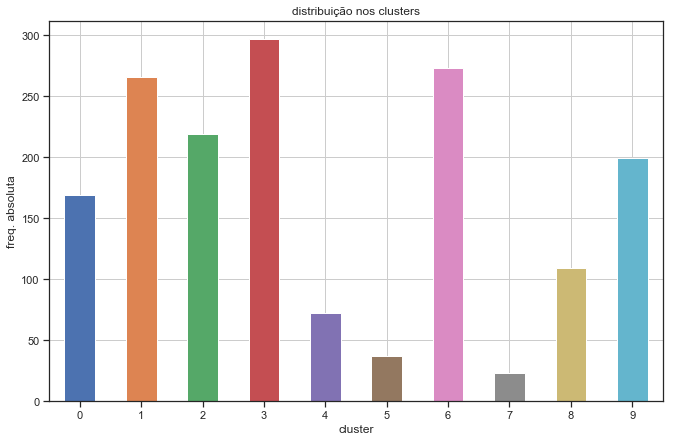

In [ ]:
filmsInClusterCount = pd.Series(data=df.groupby(['cluster']).count()[0])
plt.figure(),
filmsInClusterCount.plot.bar(x='index', y='cluster', rot=0)
plt.xlabel("cluster")
plt.grid(True)
plt.ylabel("freq. absoluta")
plt.title('distribuição nos clusters')
plt.show()

### Visualizando so resultados

com os clusters treinados, podemos prosseguir com a análise e tentar descobrir se são relevantes

C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 792x504 with 0 Axes>

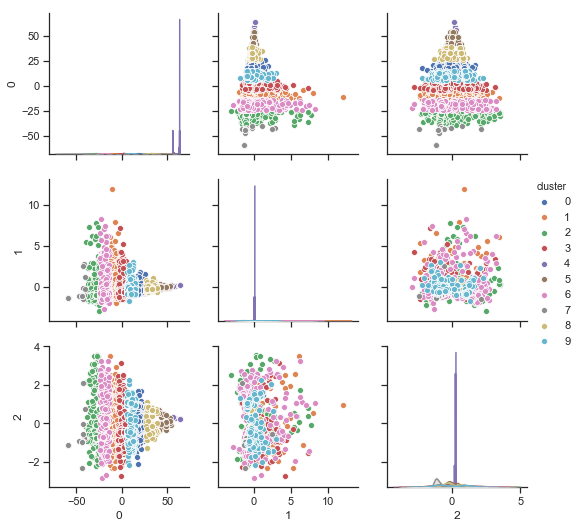

In [ ]:
plt.figure(),
g = sns.pairplot( df, hue="cluster", x_vars=df_pca.columns, y_vars=df_pca.columns)
plt.show()

##### Conclusões
> Aparentemente, os clusters usados separaram os dados (para a maioria dos clusters), com planos ortogonais ao eixo 0 do PCA.

In [ ]:
to_enrich = ratingsDF.groupby('id').agg(
    {'timestamp':'first',
     'id':'first',
     'movie_title':'first', 
     'release_date':'first',
     'unknown':'first', 
     'Action':'first', 
     'Adventure':'first', 
     'Animation':'first', 
     'Children\'s':'first',
       'Comedy':'first', 
     'Crime':'first', 
     'Documentary':'first', 
     'Drama':'first', 
     'Fantasy':'first', 
     'Film-Noir':'first',
       'Horror':'first', 
     'Musical':'first', 
     'Mystery':'first', 
     'Romance':'first', 
     'Sci-Fi':'first', 
     'Thriller':'first', 
     'War':'first',
    'Western':'first'
    })

In [ ]:
df_full = pd.concat([df, to_enrich], axis=1, join='inner')

In [ ]:
df_full[df_full['cluster'] == 0].head(10)
df_full = df_full.rename(mapper={0:'pca_0', 1:'pca_1', 2:'pca_2'}, axis='columns')

In [ ]:
df_full.head(10)

Intra cluster coesion

In [ ]:
intra_cluster_dist = []
dists_sum = []
for c in range(0, n_):
    in_cluster = df_full[df_full.cluster == c]
    centroid = np.array(kmeans.cluster_centers_[c]).reshape(1,-1)
    dists = euclidean_distances(in_cluster[["pca_0","pca_1","pca_2"]], centroid)
    sqr = np.dot(dists.reshape(-1),dists.reshape(-1))
    dists_sum.append(sqr)
    dist = dists.mean()
    cluster_sz = len(in_cluster)
    intra_cluster_dist.append([c,dist,cluster_sz])
intra_cluster_dist = pd.DataFrame(columns=['cluster', 'mean_dist', 'cluster_sz'], data=intra_cluster_dist)

Os clusters em ordem de coesão

In [ ]:
intra_cluster_dist.sort_values(['mean_dist'])

**Conclusão**
> os clusters 9 e 7 são pequenos e pouco coesos, o que pode significar que não sejam clusters de fato, mas apenas 'outliers'

In [ ]:
for c in range(0, n_):
    in_cluster = df_full[df_full.cluster == c]
    print("Cluster %i" % c)
    print(in_cluster.sample(n=10)['movie_title'])
    in_cluster.to_csv("../ProcessedData/clustering/10k/cluster_%i_kmeans.csv" % c)
    clusters_samples[c] = in_cluster

### Onde estão os filmes populares?

In [ ]:
kmeans_populares = df_full[df_full['id'].isin(popular_ids.index)]

In [ ]:
filmsInClusterCount = pd.Series(data=kmeans_populares.groupby(['cluster']).count()['pca_0'])

In [ ]:
plt.figure()
filmsInClusterCount.plot.bar()
plt.xlabel("cluster")
plt.grid(True)
plt.ylabel("freq. absoluta")
plt.title('distribuição dos filmes populares nos clusters')
plt.show()

**conclsão**
> Hà filmes populares em todos os clusters, mas são mais frequentes nos clusters 0, 2, 5 e 8

In [ ]:
for c in range(0, n_):
    in_cluster = kmeans_populares[kmeans_populares.cluster == c]
    if len(in_cluster)> 2:
        print("filmes populares do Cluster %i" % c)
        print(in_cluster.sample(n=2)['movie_title'])
        in_cluster.to_csv("../ProcessedData/clustering/10k/cluster_%i_kmeans.csv" % c)
        clusters_samples[c] = in_cluster

## DBScan usando a norma L2 como medida de dessimilaridade

Primeiro devemos determinar os hiperparâmetros
1. **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
2. **min_samples**: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

### range de EPS

Vou me basear nos valores típicos de distâncias no dataset

In [ ]:
dists = pd.Series(euclidean_distances(df_for_clustering, df_for_clustering).reshape(-1))

In [ ]:
plt.figure()
pd.Series(dists).hist()
plt.title('distribuição das distâncias entre pontos')
plt.xlabel('distância')
plt.ylabel('freqq. absoluta')
plt.show()

In [ ]:
dists.describe()

**Conclusão**
> vou fazer esse parâmetro variar dentro do primeiro quartil, ou seja, entre 0 e 10

### Treinamento

In [ ]:
def clustering_score(clustering, df):
    dists_sum = []
    intra_cluster_dist = []
    cluster_sz = []
    labels = pd.Series(clustering.labels_)
    n_ = labels.max() + 1
    for c in range(0, n_):
        in_cluster = df.iloc[clustering.labels_ == c]
        centroid = np.array(clustering.cluster_centers_[c]).reshape(1,-1)
        dists = euclidean_distances(df, centroid)
        dist = dists.mean()
        dists_sum.append(dists.sum())
        cluster_sz = len(in_cluster)
        intra_cluster_dist.append([c,dist,cluster_sz])
    intra_cluster_dist = pd.DataFrame(columns=['cluster', 'mean_dist', 'cluster_sz'], data=intra_cluster_dist)
    inertia = np.array(dists_sum).sum()
    return intra_cluster_dist, inertia

In [ ]:
eps_range = np.logspace(-2,1,num=30)
min_sample_range = np.rint(np.linspace(1,10,num=10))

Exemplo fornecido pela documentação do SKlearn da classse DBSCAN

```python
from sklearn.cluster import DBSCAN
import numpy as np
X = np.array([[1, 2], [2, 2], [2, 3],
              [8, 7], [8, 8], [25, 80]])
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
clustering.labels_
```

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
dbscan = DBSCAN(eps=.9, min_samples=6).fit(df_for_clustering)

In [ ]:
n_clusters = labels
df_clustered = df_for_clustering.copy()
df_clustered['cluster'] = dbscan.labels_

In [ ]:
# dosts, intertia = clustering_score(clustering,df_for_clustering )

In [ ]:
# %%time
# time_elapsed = []
# scores = []
# for n in eps_range:
#     for m in min_sample_range:
#         start_time = time.time()
#         dbscan = DBSCAN(eps=n, min_samples=m).fit(df_for_clustering)
#         elapsed_time = time.time() - start_time
#         dosts, intertia = clustering_score(dbscan,df_for_clustering )
#         scores.append(intertia)
#         time_elapsed.append(elapsed_time)

In [ ]:
plt.figure()
g = sns.pairplot( df_clustered, hue="cluster", x_vars=df_for_clustering.columns, y_vars=df_pca.columns)
plt.show()

In [ ]:
filmsInClusterCount = pd.Series(data=df_clustered.groupby(['cluster']).count()[0])

In [ ]:
plt.figure(),
filmsInClusterCount.plot.bar(x='index', y='cluster', rot=0)
plt.xlabel("cluster")
plt.grid(True)
plt.ylabel("freq. absoluta")
plt.title('distribuição nos clusters')
plt.show()

**Conclusão**
> A ausência do centroide dificulta um pouco a avaliação do que seria a coesão intra-cluster.
> Após algumas tentativas varrendo manualmente os parâmetros do algorítimo, achei que os clusters acima eram significativos em termos de número de filmes no cluster. Observei que:
> 
> * Se diminuimos o eps, mantendo-se o mesmo valor de min_samples, o grupo 0 aumenta e o grupo -1 (ruído) diminui
> * Se mantemos o valor de eps fixo e aumentamos o valor de min_samples, o número de clusters diminui e o tamanho do grupo -1 (ruído) também aumenta.

### Visualizando so resultados

In [ ]:
df_full2 = pd.concat([df_clustered, to_enrich], axis=1, join='inner')
df_full2 = df_full2.rename(mapper={0:'pca_0', 1:'pca_1', 2:'pca_2'}, axis='columns')

In [ ]:
df_full2.head(10)

In [ ]:
for c in range(0, n_):
    in_cluster = df_full2[df_full2.cluster == c]
    print("Cluster %i" % c)
    s_sz = (len(in_cluster),10)[10 < len(in_cluster)]
    print(in_cluster.sample(n=s_sz)['movie_title'])
    in_cluster.to_csv("../ProcessedData/clustering/10k/cluster_%i_dbscan.csv" % c)
    clusters_samples[c] = in_cluster

### Onde estão os filmes populares?

In [ ]:
dbscan_populares = df_full2[df_full2['id'].isin(popular_ids.index)]

In [ ]:
filmsInClusterCount = pd.Series(data=dbscan_populares.groupby(['cluster']).count()['pca_0'])

In [ ]:
plt.figure()
filmsInClusterCount.plot.bar()
plt.xlabel("cluster")
plt.grid(True)
plt.ylabel("freq. absoluta")
plt.title('distribuição dos filmes populares nos clusters')
plt.show()

**conclsão**
> Os filmes poplares são mais frequentes no cluster de ruído e no cluster 0. O que indica que o algoritmo foi pouco sensível a esses filmes populares ja que a maioria deles caiu no cluster do ruído

In [ ]:
for c in range(0, n_):
    in_cluster = dbscan_populares[dbscan_populares.cluster == c]
    if len(in_cluster) > 2:
        print("filmes populares do Cluster %i" % c)
        print(in_cluster.sample(n=2)['movie_title'])
        in_cluster.to_csv("../ProcessedData/clustering/10k/cluster_%i_kmeans.csv" % c)
        clusters_samples[c] = in_cluster

# Conclusão

## Na Base de 100k

**Vetores de features e PCA**

Os vetores de features (notas dadas por todos os usuários para o filme) realmente eram esparsos como se esperava. A nédia dos filmes recebeu 59 notas, mas a distribição do número de usuários que deu nota pra os filmes é altamente assimétrica e a moda da distribuição é 1. Por isso, o PCA reduziu bastante as dimensões do problema e 3 componentes representam quase 90% da energia total dos vetores de features. Com a dimensão reduzida, foi possível rodar os alogoritmos em tempo viável.

Os filmes populares, que foram definidos com aqueles com um grande número de notas diferentes de 0. Utilizei o box plot para determinar um limiar de 100 para esses filmes, o que faz com que 333 filmes sejam considerados populares.

**Clusterização KMeans**

A função de loss (somatório das distâncias ao quadrado dos pontos aos centróides de seus clusters) apresentou um "joeçho" em 10 clusters e por isso esse foi o número de clusters que foi utilizado. Os clusters obtidos pelo Kmenas
são paralelos a dimensão 0 do PCA (a de maior variância) e, a exceção de uns poucos, são formados por um grande número de filmes.

O algoritmo parece distribuiu os filmes populares entre os clusters. Eles se revelaram mais frequentes nos clusters 0, 5 e 2 que são clusters com uma grande quantidade de filmes. 

**Clusterização DBScan**

o ajuste dos hiper-parâmetros do algoritmo DBScan foi menos sistemático já que a ausência do conceito de uma função de loss que seja minimizada dificulta essa avaliação. O que se observou foi que:

* Se diminuimos o eps, mantendo-se o mesmo valor de min_samples, o grupo 0 aumenta e o grupo -1 (ruído) diminui
* Se mantemos o valor de eps fixo e aumentamos o valor de min_samples, o número de clusters diminui e o tamanho do grupo -1 (ruído) também aumenta.

O espaço de features abstrato, isto é, a transformada PCA dos vetores de features, dificultou bastante a escolha de parâmetros adequados. Por fim, observou-se que o número de pontos do conjunto de ruído é relativamente alto e o tamanho dos clusters gerados é tipicamente menor que os gerados pelo KMeans.

O algoritmo não parece sensível aos filmes populares já que a maioria deles caiu no grupo de ruído (-1).